In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# path = "/content/drive/MyDrive/Research/SDC/run_m_20"

In [3]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}

background_classes = {'cat', 'deer', 'dog', 'frog', 'horse','ship', 'truck'}

# print(type(foreground_classes))

dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):   #5000*batch_size = 50000 data points
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    
  

Files already downloaded and verified
Files already downloaded and verified


In [5]:
foreground_data.element_size()

4

In [6]:
fg1, fg2, fg3 = 0,1,2

In [7]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [8]:
# foreground_data.shape, foreground_label.shape, background_data.shape, background_label.shape

In [9]:
# val, idx = torch.max(background_data, dim=0, keepdims= True,)
# torch.abs(val)

In [10]:
# mean_bg = torch.mean(background_data, dim=0, keepdims= True)
# std_bg = torch.std(background_data, dim=0, keepdims= True)

In [11]:
# mean_bg.shape, std_bg.shape

In [12]:
# foreground_data = (foreground_data - mean_bg) / std_bg
# background_data = (background_data - mean_bg) / std_bg

In [13]:
# foreground_data.shape, foreground_label.shape, background_data.shape, background_label.shape

In [14]:
# torch.sum(torch.isnan(foreground_data)), torch.sum(torch.isnan(background_data))

In [15]:
# imshow(foreground_data[0])

In [16]:
# imshow(background_data[2])

In [17]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(20):  # m value 
    if i != fg:
      image_list.append(background_data[bg_idx[j]])
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx])
      label = foreground_label[fg_idx] - fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [18]:
desired_num = 20000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
list_set_labels = [] 
for i in range(desired_num):
  set_idx = set()
  np.random.seed(i)
  bg_idx = np.random.randint(0,35000,19)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,15000)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,20)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)
  list_set_labels.append(set_idx)

In [19]:
# mosaic_list_of_images_train = torch.stack(mosaic_list_of_images)
len(mosaic_list_of_images),mosaic_list_of_images[0].shape

(20000, torch.Size([20, 3, 32, 32]))

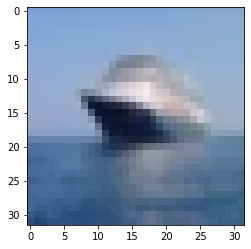

In [20]:
imshow(mosaic_list_of_images[0][1])

In [21]:
# mean_train = torch.mean(mosaic_list_of_images_train[0:2500], dim=0, keepdims= True)
# std_train = torch.std(mosaic_list_of_images_train[0:2500], dim=0, keepdims= True) 
# mosaic_list_of_images_train = (mosaic_list_of_images_train - mean_train) / std_train

In [22]:
# imshow(mosaic_list_of_images_train[0][2])

In [23]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 100
msd = MosaicDataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000] , fore_idx[0:10000])
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

test_data = MosaicDataset(mosaic_list_of_images[10000:], mosaic_label[10000:] , fore_idx[10000:])
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [24]:
del foreground_data
del background_data

In [25]:
class Focus(nn.Module):
  def __init__(self):
    super(Focus, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0, bias=False)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, bias=False)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0, bias=False)
    self.fc1 = nn.Linear(1024, 512, bias=False)
    self.fc2 = nn.Linear(512, 64, bias=False)
    self.fc3 = nn.Linear(64, 10, bias=False)
    self.fc4 = nn.Linear(10,1, bias=False)

    torch.nn.init.xavier_normal_(self.conv1.weight)
    torch.nn.init.xavier_normal_(self.conv2.weight)
    torch.nn.init.xavier_normal_(self.conv3.weight)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.xavier_normal_(self.fc2.weight)
    torch.nn.init.xavier_normal_(self.fc3.weight)
    torch.nn.init.xavier_normal_(self.fc4.weight)

  def forward(self,z):  #y is avg image #z batch of list of 9 images
    batch = z.size(0)
    patches = z.size(1)
    z = z.view(batch*patches,3,32,32)
    alpha =  self.helper(z)
    alpha = alpha.view(batch,patches,-1)
    z = z.view(batch,patches,3,32,32)
    #print(alpha.shape,z.shape)
    alpha = F.softmax(alpha,dim=1)

    x = torch.sum(alpha[:,:,:,None,None]*z,dim=1)

    #alpha =alpha.view(batch,patches,-1)



    return alpha[:,:,0],x # alpha, averaged data
    
  def helper(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    # print(x.shape)
    x = (F.relu(self.conv3(x)))
    x =  x.view(x.size(0), -1)
    # print(x.shape)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [26]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(6 * 14 * 14, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

    torch.nn.init.xavier_normal_(self.conv1.weight)
    torch.nn.init.zeros_(self.conv1.bias)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)
    torch.nn.init.xavier_normal_(self.fc2.weight)
    torch.nn.init.zeros_(self.fc2.bias)
    torch.nn.init.xavier_normal_(self.fc3.weight)
    torch.nn.init.zeros_(self.fc3.bias)
    torch.nn.init.xavier_normal_(self.fc4.weight)
    torch.nn.init.zeros_(self.fc4.bias)

  def forward(self,z): 
    y1 = self.pool(F.relu(self.conv1(z)))
    #print(y1.shape)
    y1 = y1.view(-1, 6 * 14 * 14)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 

In [27]:
set_seed = 13
torch.manual_seed( set_seed )
focus_net = Focus().double()
focus_net = focus_net.to("cuda")

In [28]:
focus_net.fc3.weight.shape,focus_net.fc4.weight.shape

(torch.Size([10, 64]), torch.Size([1, 10]))

In [29]:
focus_net.fc3.weight.data[5:,:] = focus_net.fc3.weight.data[:5,:] #torch.nn.Parameter(torch.tensor([last_layer]) )
# (focus_net.fc3.weight[:5,:]== focus_net.fc3.weight[5:,:] )

In [30]:
focus_net.fc4.weight.data[:,5:] = -focus_net.fc4.weight.data[:,:5] #torch.nn.Parameter(torch.tensor([last_layer]) )
# focus_net.fc4.weight

In [31]:
focus_net = focus_net.double().to("cuda")

In [32]:
# alpha,output = focus_net( torch.randn((128,50,3,32,32)).double().to("cuda") )

In [33]:
# alpha.shape,output.shape

In [34]:
torch.manual_seed(set_seed)
classify = Classification().double()
classify = classify.to("cuda")

In [35]:
# classify.conv1.bias

In [36]:
# classify.fc1.weight

In [37]:
# classify.fc1.bias

In [38]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer_classify = optim.Adam(classify.parameters(), lr=0.0005  ) #, momentum=0.9)
optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.0005  ) #, momentum=0.9)

In [39]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [40]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    # print(alphas)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

col1.append(0)
col2.append(argmax_more_than_half)
col3.append(argmax_less_than_half)
col4.append(focus_true_pred_true)
col5.append(focus_false_pred_true)
col6.append(focus_true_pred_false)
col7.append(focus_false_pred_false)

Accuracy of the network on the 30000 train images: 33.480000 %
total correct 3348
total train set images 10000
focus_true_pred_true 148 =============> FTPT : 1.480000 %
focus_false_pred_true 3200 =============> FFPT : 32.000000 %
focus_true_pred_false 364 =============> FTPF : 3.640000 %
focus_false_pred_false 6288 =============> FFPF : 62.880000 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  10000
10000


In [41]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
col8.append(argmax_more_than_half)
col9.append(argmax_less_than_half)
col10.append(focus_true_pred_true)
col11.append(focus_false_pred_true)
col12.append(focus_true_pred_false)
col13.append(focus_false_pred_false)

Accuracy of the network on the 10000 test images: 33.100000 %
total correct 3310
total train set images 10000
focus_true_pred_true 155 =============> FTPT : 1.550000 %
focus_false_pred_true 3155 =============> FFPT : 31.550000 %
focus_true_pred_false 339 =============> FTPF : 3.390000 %
focus_false_pred_false 6351 =============> FFPF : 63.510000 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  10000


In [42]:
nos_epochs = 200
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0


for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    inputs = inputs.double()
    # zero the parameter gradients
    
    optimizer_focus.zero_grad()
    optimizer_classify.zero_grad()
    
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion(outputs, labels) 
    loss.backward()
    optimizer_focus.step()
    optimizer_classify.step()

    running_loss += loss.item()
    mini = 20
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1
    
    if epoch % 5 == 0:
      for j in range (inputs.size(0)):
        #print(alphas.shape)
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

  if(np.mean(epoch_loss) <= 0.05):
      break;

  if epoch % 5 == 0:
    col1.append(epoch + 1)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
    print("="*20)
    print("Train FTPT : ", col4)
    print("Train FFPT : ", col5)
    #************************************************************************
    #testing data set  
    # focus_net.eval()
    with torch.no_grad():
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0

      argmax_more_than_half = 0
      argmax_less_than_half =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs = inputs.double()
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        alphas, avg_images = focus_net(inputs)
        outputs = classify(avg_images)
        _, predicted = torch.max(outputs.data, 1)

        for j in range (inputs.size(0)):
          focus = torch.argmax(alphas[j],dim=-1)

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
      
    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)
    print("Test FTPT : ", col10)
    print("Test FFPT : ", col11)
    print("="*20)
    
print('Finished Training')

[1,    20] loss: 1.102
[1,    40] loss: 1.096
[1,    60] loss: 1.095
[1,    80] loss: 1.096
[1,   100] loss: 1.095
Train FTPT :  [148, 262]
Train FFPT :  [3200, 3367]
Test FTPT :  [155, 565]
Test FFPT :  [3155, 3137]
[2,    20] loss: 1.085
[2,    40] loss: 1.091
[2,    60] loss: 1.085
[2,    80] loss: 1.081
[2,   100] loss: 1.068
[3,    20] loss: 1.066
[3,    40] loss: 1.061
[3,    60] loss: 1.069
[3,    80] loss: 1.056
[3,   100] loss: 1.046
[4,    20] loss: 1.050
[4,    40] loss: 1.041
[4,    60] loss: 1.041
[4,    80] loss: 1.047
[4,   100] loss: 1.039
[5,    20] loss: 1.031
[5,    40] loss: 1.029
[5,    60] loss: 1.027
[5,    80] loss: 1.012
[5,   100] loss: 1.013
[6,    20] loss: 0.994
[6,    40] loss: 0.988
[6,    60] loss: 0.991
[6,    80] loss: 0.957
[6,   100] loss: 0.984
Train FTPT :  [148, 262, 2061]
Train FFPT :  [3200, 3367, 3032]
Test FTPT :  [155, 565, 2031]
Test FFPT :  [3155, 3137, 2893]
[7,    20] loss: 0.951
[7,    40] loss: 0.936
[7,    60] loss: 0.942
[7,    80] lo

In [43]:
# torch.save(focus_net.state_dict(),path+"_focus.pt")
# torch.save(classify.state_dict(),path+"_classify.pt")

In [44]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [45]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]

In [46]:
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [47]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,10000,148,3200,364,6288
1,1,0,10000,262,3367,565,5806
2,6,1431,8569,2061,3032,791,4116
3,11,3810,6190,3735,2943,665,2657
4,16,4993,5007,4670,3035,431,1864
5,21,5448,4552,5195,3206,280,1319
6,26,5810,4190,5478,3434,152,936
7,31,5849,4151,5663,3648,80,609
8,36,5745,4255,5697,3833,44,426
9,41,5516,4484,5697,3989,29,285


In [48]:
# df_train.to_csv(path+"_train.csv",index=False)

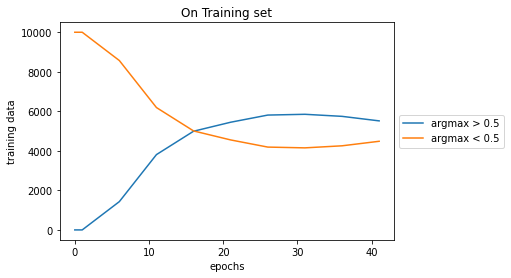

In [49]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()



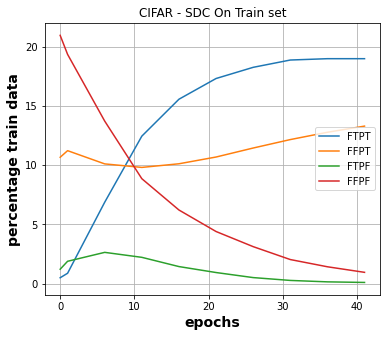

In [50]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col4)/300, label ="FTPT")
plt.plot(col1,np.array(col5)/300, label ="FFPT")
plt.plot(col1,np.array(col6)/300, label ="FTPF")
plt.plot(col1,np.array(col7)/300, label ="FFPF")
plt.title("CIFAR - SDC On Train set")
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage train data", fontsize=14, fontweight = 'bold')
# plt.savefig(path+"cifar_train.png", bbox_inches="tight")
# plt.savefig(path+"cifar_train.pdf", bbox_inches="tight")
# plt.savefig(path+"cifar_train.png", bbox_inches="tight")
# plt.savefig(path+"cifar_train.pdf", bbox_inches="tight")
plt.show()

In [51]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,10000,155,3155,339,6351
1,1,0,10000,565,3137,722,5576
2,6,805,9195,2031,2893,860,4216
3,11,3811,6189,3506,2609,837,3048
4,16,4946,5054,3972,2382,774,2872
5,21,4907,5093,4286,2409,672,2633
6,26,5039,4961,4479,2281,618,2622
7,31,5111,4889,4517,2115,600,2768
8,36,5035,4965,4440,2322,689,2549
9,41,4925,5075,4462,2279,682,2577


In [52]:
# df_test.to_csv(path+"_test.csv",index=False)

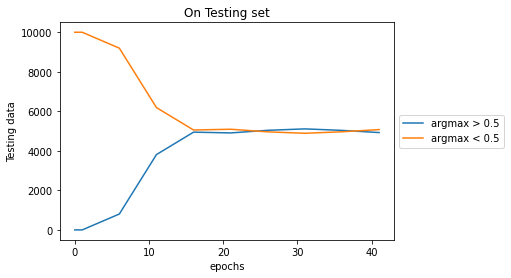

In [53]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()



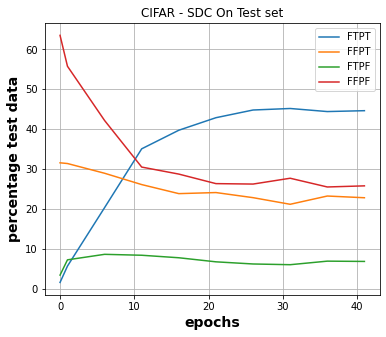

In [54]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col10)/100, label ="FTPT")
plt.plot(col1,np.array(col11)/100, label ="FFPT")
plt.plot(col1,np.array(col12)/100, label ="FTPF")
plt.plot(col1,np.array(col13)/100, label ="FFPF")
plt.title("CIFAR - SDC On Test set")
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage test data", fontsize=14, fontweight = 'bold')
# plt.savefig(path+"cifar_test.png", bbox_inches="tight")
# plt.savefig(path+"cifar_test.pdf", bbox_inches="tight")
# plt.savefig(path+"cifar_test.png", bbox_inches="tight")
# plt.savefig(path+"cifar_test.pdf", bbox_inches="tight")
plt.show()

In [55]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  train images: %f %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the  train images: 99.180000 %
total correct 9918
total train set images 10000
focus_true_pred_true 5783 =============> FTPT : 57.830000 %
focus_false_pred_true 4135 =============> FFPT : 41.350000 %
focus_true_pred_false 5 =============> FTPF : 0.050000 %
focus_false_pred_false 77 =============> FFPF : 0.770000 %
argmax_more_than_half ==================>  5326
argmax_less_than_half ==================>  4674


In [56]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  test images: %f %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the  test images: 67.030000 %
total correct 6703
total train set images 10000
focus_true_pred_true 4455 =============> FTPT : 44.550000 %
focus_false_pred_true 2248 =============> FFPT : 22.480000 %
focus_true_pred_false 668 =============> FTPF : 6.680000 %
focus_false_pred_false 2629 =============> FFPF : 26.290000 %
argmax_more_than_half ==================>  4660
argmax_less_than_half ==================>  5340


In [57]:
correct = 0
total = 0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  train images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the  train images: 99.180000 %
total correct 9918
total train set images 10000


In [58]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 10000 test images: 67.030000 %
total correct 6703
total train set images 10000
